In [1]:
from scipy import spatial

Let's consider a very "toy example" where we have 4 users, who rated two movies

In [2]:
a = [1, 2]
b = [2, 4]
c = [2.5, 4]
d = [4.5, 5]

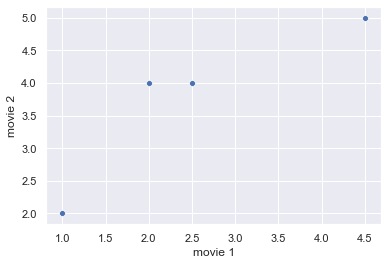

In [8]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from pandas import DataFrame
data = {"movie 1": [elem[0] for elem in [a,b,c,d]], "movie 2": [elem[1] for elem in [a,b,c,d]]}
data_points = DataFrame(data)

ax = sns.scatterplot(x="movie 1", y="movie 2", data=data_points)

Let's find out their similarity

As said before, the cosine distance measures the angle between the vectors who define the data points (in this case, the users).

In [9]:
spatial.distance.cosine(c,a)

0.004504527406047898

In [10]:
spatial.distance.cosine(c,b)

0.004504527406047898

In [11]:
spatial.distance.cosine(c,d)

0.015137225946083022

In [12]:
spatial.distance.cosine(a,b)

0.0

Users a and b are very similar (cosine distance is zero). They're a re-scaled version of each other. One is just more picky (but has the same "relative" taste).

The ultimate goal is to find the best movies to recommend to each user. 

We want to estimate the rating that each user would give to those unrated movies.

To do that, we find the top n most similar users, and then average their rating on those movies he hadn't seen. 

<div>
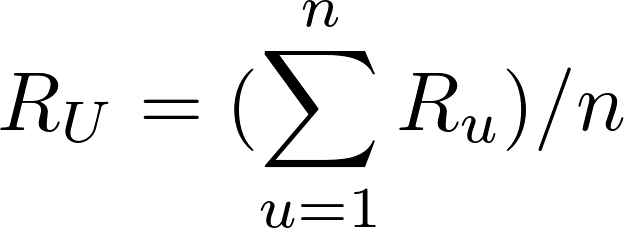
</div>

Better, if we use a similarity score for each user:

<div>
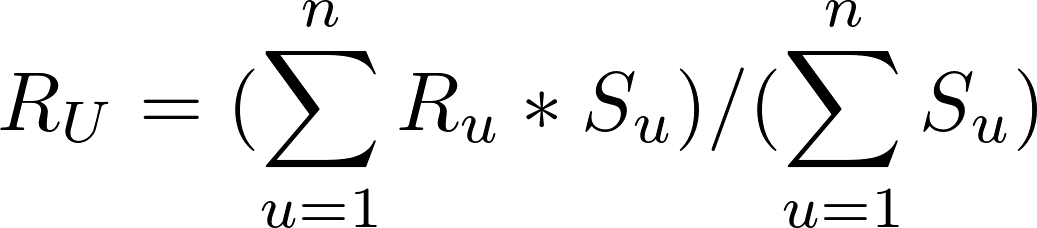
</div>

We've learned:
 - how to find similar users (use cosine distance between their vectors) and
 - how to calculate ratings based on their ratings. 


Obviously, it goes without saying, that looping through the users is feasible in a short dataset, but in a real world scenario, you would want to index the users and perform the retrieval step there (looping through all the users has a O(n) complexity).

One such search engines is Facebook's Faiss: "Faiss is a library for efficient similarity search and clustering of dense vectors.", https://github.com/facebookresearch/faiss

This process of using the ratings matrix to find similar users (user-based collaborative filtering), can also be applied to find similar items, based on the ratings they receive from the users (item-based collaborative filtering).

Item-based collaborative filtering is used in companies like Amazon. 
It's suited for systems with more users than items (faster and more stable). 
It's effective because the average rating given to an item 
doesn’t change as quickly as the average rating given by a user to different items. 

It’s also known to perform better than the user-based approach 
when the ratings matrix is sparse.

### Building a movie recommender using the scikit-surprise library

In [13]:
import pandas as pd
from surprise import Dataset
from surprise import Reader

In [14]:
# same data as before, plus new user E
ratings_dict = {
    "item": [1, 2, 1, 2, 1, 2, 1, 2, 1],
    "user": ['A', 'A', 'B', 'B', 'C', 'C', 'D', 'D', 'E'],
    "rating": [1, 2, 2, 4, 2.5, 4, 4.5, 5, 3],
}

In [15]:
df = pd.DataFrame(ratings_dict)
reader = Reader(rating_scale=(1, 5))

In [22]:
# Loads Pandas dataframe
data = Dataset.load_from_df(df[["user", "item", "rating"]], reader)

In [17]:
from surprise import KNNWithMeans

# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute  similarities between items
}
algo = KNNWithMeans(sim_options=sim_options)
#This recommender is configured to use the cosine similarity and 
#to find similar items using the item-based approach.

In [19]:
trainingSet = data.build_full_trainset()

In [20]:
algo.fit(trainingSet)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [21]:
prediction = algo.predict('E', 2)
print(prediction.est)

4.15


 ### Using the movie lens dataset
 #### Using Centered-KNN algorithm


In [24]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise.model_selection import GridSearchCV

# Loads the builtin Movielens-100k data
data = Dataset.load_builtin('ml-100k')

In [25]:
sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [3, 4],
    "user_based": [False, True],
}
# name contains the similarity metric to use. 
#     Options are cosine, msd, pearson, or pearson_baseline. The default: msd.
# user_based is a boolean that tells whether the approach 
#     will be user-based or item-based. The default is True, 
#     which means the user-based approach will be used.
# min_support is the minimum number of common items needed 
#     between users to consider them for similarity. 
#     For the item-based approach, this corresponds to the 
#     minimum number of common users for two items.

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [26]:
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

0.9440860162441234
{'sim_options': {'name': 'msd', 'min_support': 3, 'user_based': False}}


Best parameters for Centered-KNN algorithm are: metric: Mean Squared Difference; Item-based approach and minimum 3 common users for two items.

#### Using the SVD approach

In [27]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV

param_grid = {
    "n_epochs": [5, 10],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6]
}
# n_epochs is the number of iterations of SGD, 
#     which is basically an iterative method used in Statistics 
#     to minimize a function.
# lr_all is the learning rate for all parameters, which is a parameter that 
#     decides how much the parameters are adjusted in each iteration.
# reg_all is the regularization term for all parameters, 
#     which is a penalty term added to prevent overfitting.
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(data)

In [28]:
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

0.9645530175378766
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


Best parameters for SVD algorithm are: 10 epochs; learning rate of 0.005 and regularization of 0.4.

#### Research papers:
- "Item-Based Collaborative Filtering Recommendation
Algorithms": http://files.grouplens.org/papers/www10_sarwar.pdf
- "Using collaborative filtering to weave an information tapestry": https://scinapse.io/papers/1966553486
        

heavily based on https://realpython.com/build-recommendation-engine-collaborative-filtering/